In [5]:
# Import some of the stuff we will need
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as io
from demregpy import dn2dem
import demregpy

import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams['font.size'] = 16


The most basic demonstration of a DEM model is to produce synthetic data by applying instrument responses to a synthetic DEM and ensuring the synthetic DEM can be recovered.

We have to be careful by putting too much faith in the ability of the code to recover the synthetic DEM as in the demonstration the same instrument response that generated the DN values is also used by the DEM code when in reality the real instrument response is likely imperfect.

In [102]:
# Load in the SSWIDL generated response functions
# Was produced by make_aiaresp_forpy.pro (can't escape sswidl that easily....)
trin=io.readsav('H://demregpy/demregpy/aia_tresp_en.dat')

# Get rid of the b in the string name (byte vs utf stuff....)
for i in np.arange(len(trin['channels'])):
    trin['channels'][i]=trin['channels'][i].decode("utf-8")

# Get the temperature response functions in the correct form for demreg
tresp_logt=np.array(trin['logt'])
nt=len(tresp_logt)
nf=len(trin['tr'][:])
trmatrix=np.zeros((nt,nf))
for i in range(0,nf):
    trmatrix[:,i]=trin['tr'][i]
matplotlib.rcParams['font.size'] = 16

# Setup some AIA colours
clrs=['darkgreen','darkcyan','gold','sienna','indianred','darkslateblue']
# For some DEM model (i.e. a Gaussian) produce the synthetic DN/s/px for each AIA channel
d1=4e22
m1=6.5
s1=0.15
root2pi=(2.*math.pi)**0.5
dem_mod=(d1/(root2pi*s1))*np.exp(-(tresp_logt-m1)**2/(2*s1**2))

# Now work out the DN/s/px
# For AIA responses all are dlogt=0.05
tresp_dlogt=np.full(nt,0.05)
tc_full=np.zeros([nt,nf])
for i in range(0,nf):
    tc_full[:,i]=dem_mod*trmatrix[:,i]*10**tresp_logt*np.log(10**tresp_dlogt)

dn_in=np.sum(tc_full,0)
print('dn_in: ',dn_in)

# And the associated uncertainty (no systematics)
gains=np.array([18.3,17.6,17.7,18.3,18.3,17.6])
dn2ph=gains*np.array([94,131,171,193,211,335])/3397.
rdnse=np.array([1.14,1.18,1.15,1.20,1.20,1.18])
# assume all obs were 2.9s long
dn0=dn_in*2.9
shotnoise=(dn2ph*dn0)**0.5/dn2ph/2.9
# error in DN/s/px
edn_in=(rdnse**2+shotnoise**2)**0.5 
print('edn_in: ',edn_in)

dn_in:  [  326.11015434   313.31711078  2663.51032758 11361.19773432
  8700.35614133  1208.36625462]
edn_in:  [14.94543538 12.67184957 32.12696435 61.39593311 51.38885685 15.53907416]


Now we have DN and DN errors for our data, the DEM code takes these, along with the temperature response, the range of temperatures the tresp covers and the target temperature bins for the DEM to target as input.

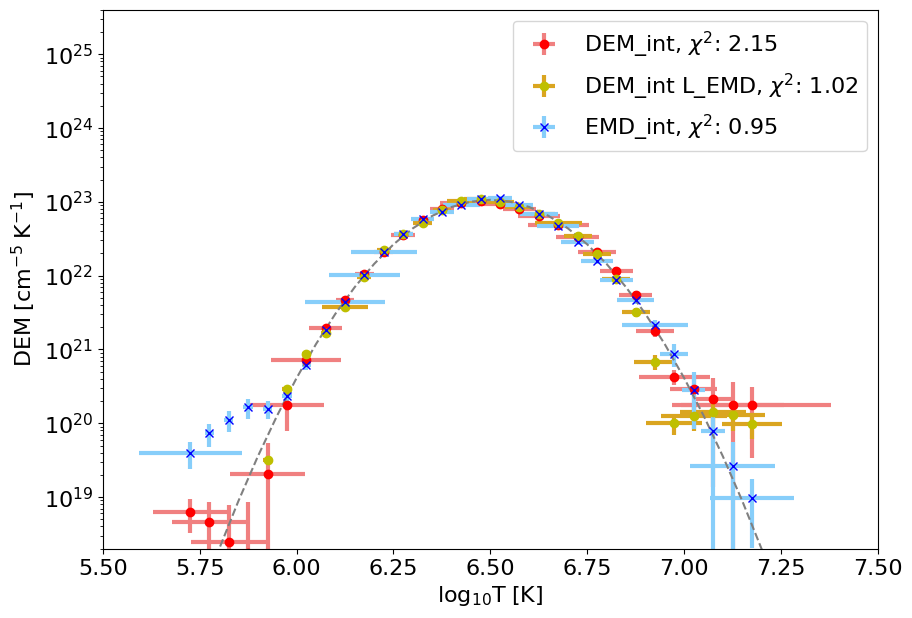

In [103]:
# set up our target dem temps
mint=5.7
maxt=7.2
# the tresp resolution is 0.05 logt so cant use a resolution finger than that
dlogt=0.05
temps=10**np.arange(mint,maxt+dlogt,dlogt)
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])
dem0,edem0,elogt0,chisq0,dn_reg0=dn2dem(dn_in,edn_in,trmatrix,tresp_logt,temps)
dem0b,edem0b,elogt0b,chisq0b,dn_reg0b=dn2dem(dn_in,edn_in,trmatrix,tresp_logt,temps,l_emd=True)
dem1,edem1,elogt1,chisq1,dn_reg1=dn2dem(dn_in,edn_in,trmatrix,tresp_logt,temps,emd_int=True,emd_ret=False,gloci=1)

#  Plot it
yr=[2e18,4e25]
xr=[5.5,7.5] #np.log10([min(temps),max(temps)])
fig = plt.figure(figsize=(10, 7))
plt.errorbar(mlogt,dem0,xerr=elogt0,yerr=edem0,fmt='or',\
             ecolor='lightcoral', elinewidth=3, capsize=0,label='DEM_int, $\chi^2$: {:0.2f}'.format(chisq0))
plt.errorbar(mlogt,dem0b,xerr=elogt0b,yerr=edem0b,fmt='oy',\
             ecolor='goldenrod', elinewidth=3, capsize=0,label='DEM_int L_EMD, $\chi^2$: {:0.2f}'.format(chisq0b))
plt.errorbar(mlogt,dem1,xerr=elogt1,yerr=edem1,fmt='xb',\
             ecolor='lightskyblue', elinewidth=3, capsize=0,label='EMD_int, $\chi^2$: {:0.2f}'.format(chisq1))
plt.plot(tresp_logt,dem_mod,'--',color='grey')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim(yr)
plt.xlim(xr)
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend()
plt.show()

# print(chisq0,chisq0b,chisq1)
# print(100*dn_reg0/dn_in)
# print(100*dn_reg0b/dn_in)
# print(100*dn_reg1/dn_in)

#  L_EMD not that bad here either.....

Warning, positivity loop hit max iterations, so increase max_iter? Or rgt_fact too small?
Warning, positivity loop hit max iterations, so increase max_iter? Or rgt_fact too small?


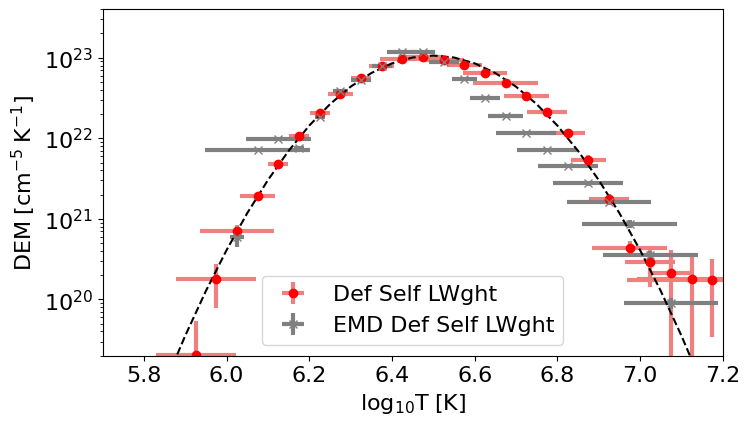

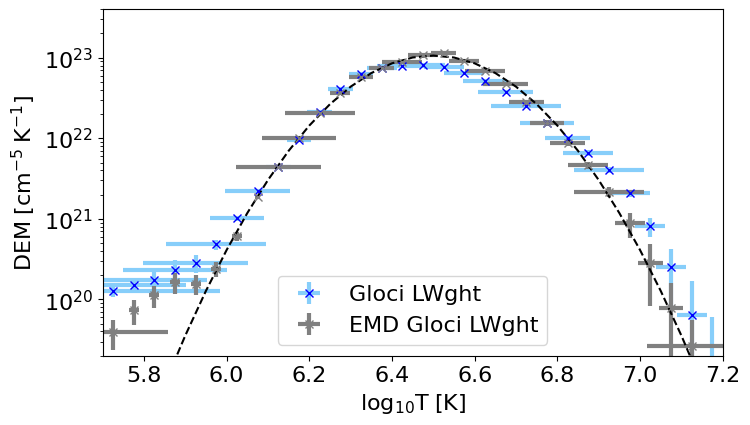

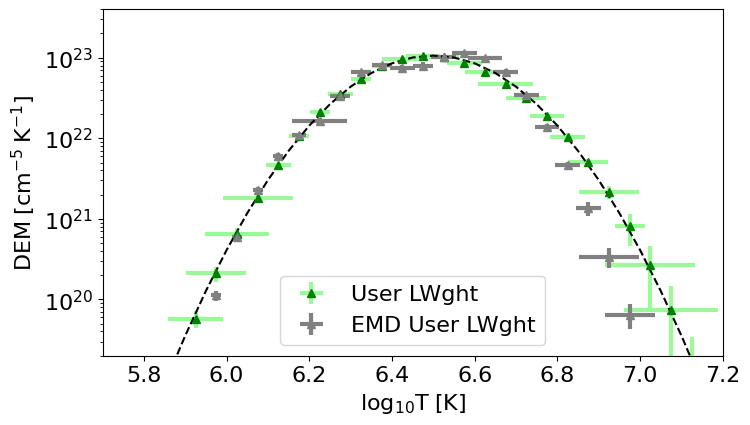

In [8]:
mint=5.7
maxt=7.2
dlogt=0.05
temps=10**np.arange(mint,maxt+dlogt,dlogt)
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])

# Now work out the DEM - investigate 3 standard ways of running
# 1. Default - reg runs twice, 1st time to work out weight for constraint matrix, then regs with that
#         Best option if don't know what doing, hence its the default 
dem0,edem0,elogt0,chisq0,dn_reg0=dn2dem(dn_in,edn_in,trmatrix,tresp_logt,temps)
dem0a,edem0a,elogt0a,chisq0a,dn_reg0a=dn2dem(dn_in,edn_in,trmatrix,tresp_logt,temps,emd_int=True) #needs bigger max_iter
# 2. EMloci - reg runs once, works out weight for constraint matrix as min of EM Loci, then regs with that
#        If some of your filters have a sharper T response (lines or X-ray obs) might be useful to try
dem1,edem1,elogt1,chisq1,dn_reg1=dn2dem(dn_in,edn_in,trmatrix,tresp_logt,temps,gloci=1) #needs bigger max_iter
dem1a,edem1a,elogt1a,chisq1a,dn_reg1a=dn2dem(dn_in,edn_in,trmatrix,tresp_logt,temps,gloci=1,emd_int=True)
# 3. User weight - reg runs once, user provide weight for constraint matrix L, then regs with that
#         If have an idea of what DEM might look like could try a rough form of it (though check vs 1, 2 above)
# As working with synthetic data from DEM model, could try weighting by this model, interp on output DEM T bins
demwght0=10**np.interp(mlogt,tresp_logt,np.log10(dem_mod))
dem2,edem2,elogt2,chisq2,dn_reg2=dn2dem(dn_in,edn_in,trmatrix,tresp_logt,temps,dem_norm0=demwght0/max(demwght0))
dem2a,edem2a,elogt2a,chisq2a,dn_reg2a=dn2dem(dn_in,edn_in,trmatrix,tresp_logt,temps,dem_norm0=demwght0/max(demwght0),emd_int=True)

#  Plot it all
yr=[2e19,4e23]
xr=[5.7,7.2]#np.log10([min(temps),max(temps)])
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem0,xerr=elogt0,yerr=edem0,fmt='or',\
             ecolor='lightcoral', elinewidth=3, capsize=0,label='Def Self LWght')
plt.errorbar(mlogt,dem0a,xerr=elogt0a,yerr=edem0a,fmt='x',color='grey',\
             ecolor='grey', elinewidth=3, capsize=0,label='EMD Def Self LWght')
plt.plot(tresp_logt,dem_mod,'--',color='black')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim(yr)
plt.xlim(xr)
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend()
plt.show()

#  Plot it all
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem1,xerr=elogt1,yerr=edem1,fmt='xb',\
             ecolor='lightskyblue', elinewidth=3, capsize=0,label='Gloci LWght')
plt.errorbar(mlogt,dem1a,xerr=elogt1a,yerr=edem1a,fmt='x',color='grey',\
             ecolor='grey', elinewidth=3, capsize=0,label='EMD Gloci LWght')
plt.plot(tresp_logt,dem_mod,'--',color='black')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim(yr)
plt.xlim(xr)
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend()
plt.show()

#  Plot it all
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem2,xerr=elogt2,yerr=edem2,fmt='^g',\
             ecolor='palegreen', elinewidth=3, capsize=0,label='User LWght')
plt.errorbar(mlogt,dem2a,xerr=elogt2a,yerr=edem2a,fmt='^',color='grey',\
             ecolor='grey', elinewidth=3, capsize=0,label='EMD User LWght') 
plt.plot(tresp_logt,dem_mod,'--',color='black')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim(yr)
plt.xlim(xr)
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend()
plt.show()


# Basically conclusion than EMD works well if gloci approach can be used?

In [9]:
# #  How well did they actually do?
print('Def Self, chisq: ',chisq0,chisq0a) # Not bad....
print('Gloci, chisq: ',chisq1,chisq1a) # Worse of 3 but expected as just working with AIA filters here (unless EMD)
print('User, chisq: ',chisq2,chisq2a) # Know the answer so unsurprising this LWght gives best answer!

print('Def Self: ',dn_reg0/dn_in)
print('Gloci: ',dn_reg1/dn_in)
print('User: ',dn_reg2/dn_in)

# fig,ax = plt.subplots(figsize=(8, 6))
# plt.scatter(dn_in,dn_reg0,color='red',marker='o',s=50,lw=2,label='DefSelf')
# plt.scatter(dn_in,dn_reg1,color='blue',marker='x',s=50,lw=2,label='Gloci')
# plt.scatter(dn_in,dn_reg2,color='green',marker='^',s=50,lw=2,label='USer')
# for i, lab in enumerate(trin['channels']):
#     ax.annotate(lab, (dn_in[i], 0.6*dn_reg0[i]),color=clrs[i],fontsize=12)
# plt.xlabel('DN_in')
# plt.ylabel('DN_reg')
# xyrang=[1e2,2e4]
# plt.plot(xyrang,xyrang,color='grey',ls='dashed')
# plt.ylim(xyrang)
# plt.xlim(xyrang)
# plt.rcParams.update({'font.size': 16})
# plt.yscale('log')
# plt.xscale('log')
# plt.legend()
# plt.show()

Def Self, chisq:  2.1526870575465065 38.6528713879554
Gloci, chisq:  38.3632204152755 0.9486849838761694
User, chisq:  0.9811417950943057 0.9696691240356611
Def Self:  [0.97185562 1.00420274 1.00037497 0.99957419 0.99971148 0.95450068]
Gloci:  [0.84631523 1.01956178 1.00143276 1.0008652  0.98111212 0.81434305]
User:  [0.95037928 0.99759372 0.99959576 0.9995356  0.9996398  0.97212471]


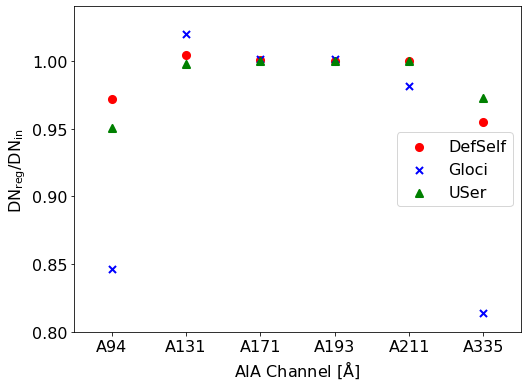

In [21]:
#  Or compare in terms of ratio
fig,ax = plt.subplots(figsize=(8, 6))
plt.scatter(np.arange(6),dn_reg0/dn_in,marker='o',color='red',s=50,lw=2,label='DefSelf')
plt.scatter(np.arange(6),dn_reg1/dn_in,marker='x',color='blue',s=50,lw=2,label='Gloci')
plt.scatter(np.arange(6),dn_reg2/dn_in,marker='^',color='green',s=50,lw=2,label='USer')
plt.ylim([0.80,1.04])
plt.xlim([-0.5,5.5])
plt.xticks(np.arange(6),trin['channels'])
plt.xlabel('AIA Channel [$\mathrm{\AA}$]')
plt.ylabel('DN$_\mathrm{reg}$/DN$_\mathrm{in}$')
plt.locator_params(axis='y', nbins=5)
plt.legend()
plt.show()

---

In [104]:
# # Now lets try making a 1D array (really 2D as t,f) from our synthetic pixel 
# # This could also be a map position-slice or pixel/region average changing with time

nt=12
# Only input data and error needs the extra dimensions here - TR resp and T binnings as before
dn_in2d=np.zeros([nt,nf])
edn_in2d=np.zeros([nt,nf])
for t in np.arange(nt):
# Giving some time dependance to our synthetic data so we can see the change in the DEMogram
# Obviously with real data you wouldn't need to do this
    dn_in2d[t,:]=dn_in*(1+(t*6.)/nt)
# Just use 10% for error as changed data - again with real data use the full error calculation
    edn_in2d[t,:]=0.1*dn_in
    
# Now do the DEMogram calculation    
dem1d,edem1d,elogt1d,chisq1d,dn_reg1d=dn2dem(dn_in2d,edn_in2d,trmatrix,tresp_logt,temps)

# print('DN_reg: ',dn_reg1d[0,:])
# print('chisq: ',chisq1d[0])

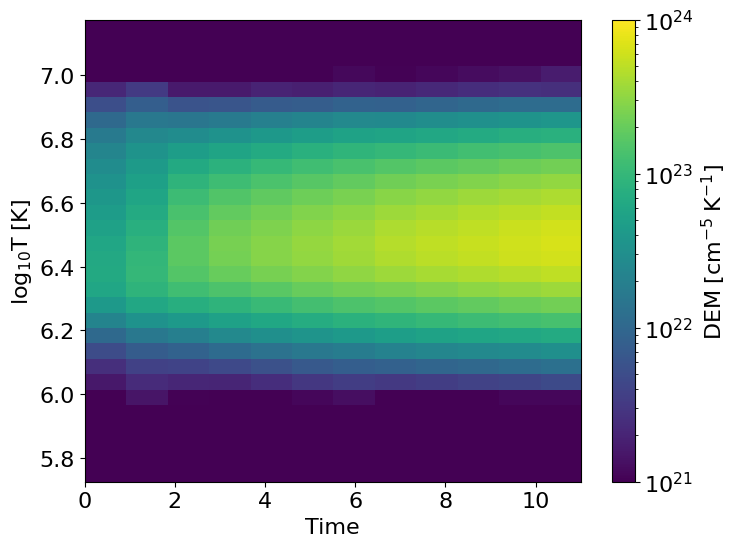

In [105]:
# Can plot t (or position) vs logT, producing a DEMogram
fig,ax = plt.subplots(figsize=(8, 6))
plt.imshow(dem1d.T,aspect='auto',origin='lower',norm=matplotlib.colors.LogNorm(vmin=1e21, vmax=1e24),\
           extent=[0,nt-1,min(mlogt),max(mlogt)])
plt.ylabel('$\mathrm{\log_{10}T\;[K]}$')
plt.xlabel('Time')
plt.colorbar(label='$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.show()

#  A vertical slice of the below plot would give the standard DEM plot of DEM vs logT

In [12]:
# # Now lets try making a 2D array (really 3D as x,y,f) from our synthetic pixel 
# # to test speed of the code with a AIA "maps":
# # If lot's of data code automatically runs in parallel instead of serial

nx=57
ny=42
# Only input data and error needs the extra dimensions here - TR resp and T binnings as before
dn_in2d=np.zeros([nx,ny,nf])
edn_in2d=np.zeros([nx,ny,nf])

for y in np.arange(ny):
    for x in np.arange(nx):
        # Giving some x,y dependance to our synthetic data so we can see the change in the DEM maps
        # Obviously with real data you wouldn't need to do this
        dn_in2d[x,y,:]=dn_in *(1+(y*3./ny)+(x*4./nx))
        # Just use 10% for error as changed data - again with real data use the full error calculation
        edn_in2d[x,y,:]=0.1*dn_in 
        
#  Do slightly differnt binning for these DEMs
t_space=0.05
t_min=5.6
t_max=7.4
logtemps=np.linspace(t_min,t_max,num=int((t_max-t_min)/t_space)+1)
temps=10**logtemps   
        
# Now do the DEM maps calculation           
dem2d,edem2d,elogt2d,chisq2d,dn_reg2d=dn2dem(dn_in2d,edn_in2d,trmatrix,tresp_logt,temps)


100%|██████████| 23.0/23.0 [00:56<00:00, 2.44s/ x10^2 DEM]


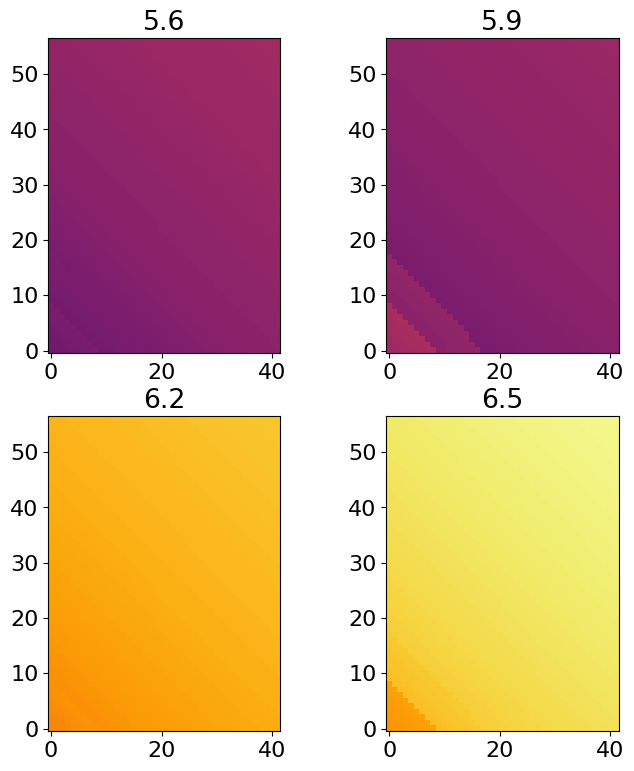

In [13]:
fig=plt.figure(figsize=(8, 9))
for j in range(4):
    fig=plt.subplot(2,2,j+1)
    plt.imshow(np.log10(dem2d[:,:,j*6]+1e-20),'inferno',vmin=18,vmax=24,origin='lower')
    ax=plt.gca()
    ax.set_title('%.1f'%(5.6+j*6*0.05))

In [14]:
from sunpy.net import Fido, attrs
from sunpy.map import Map
from astropy import units as u, time as time

In [62]:
time_test = time.Time('2014-01-01T00:00:00', scale='utc')
wavenum=['94','131','171','193','211','335']
nt=16
temperatures=10**np.linspace(5.7,7.1,num=nt+1)
logtemps=np.linspace(5.7,7.1,num=nt+1)
channels=[]
for i in np.arange(len(wavenum)):
    channels.append(float(wavenum[i])*u.angstrom)
fits_dir="H:/test/"
td = time.TimeDelta(11,format='sec')



In [16]:
q=Fido.search(
    attrs.Time(time_test, time_test+td),
    attrs.Instrument('AIA'),
    attrs.Wavelength(channels[0]) | attrs.Wavelength(channels[1]) | attrs.Wavelength(channels[2]) | attrs.Wavelength(channels[3]) | attrs.Wavelength(channels[4]) | attrs.Wavelength(channels[5]),
)
print(q)
files=Fido.fetch(q, path=fits_dir)

Results from 6 Providers:

1 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 67.789 Mbyte

       Start Time       ...
                        ...
----------------------- ...
2014-01-01 00:00:01.000 ...

1 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 67.789 Mbyte

       Start Time       ...
                        ...
----------------------- ...
2014-01-01 00:00:08.000 ...

1 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 67.789 Mbyte

       Start Time       ...
                        ...
----------------------- ...
2014-01-01 00:00:11.000 ...

1 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 67.789 Mbyte

       Start Time       ...
                        ...
----------------------- ...
2014-01-01 00:00:06.000 ...

1 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin

Files Downloaded:   0%|          | 0/6 [00:00<?, ?file/s]

In [26]:
from aiapy.calibrate import degradation, register, update_pointing, correct_degradation
from aiapy.calibrate.util import get_correction_table
maps = [Map(f) for f in files]
maps = sorted(maps, key=lambda x: x.wavelength)
# maps = [aiaprep(m) for m in maps]
maps = [correct_degradation(m)/m.exposure_time for m in maps]

In [49]:
nx=int(maps[0].dimensions.x.value)
ny=int(maps[0].dimensions.y.value)
nf=len(files)
data=np.zeros([nx,ny,nf])
#convert from our list to an array of data
for j in np.arange(nf):
    data[:,:,j]=maps[j].data
data[data < 0]=0
serr_per=10.0
#errors in dn/px/s
npix=4096.**2/(nx*ny)
edata=np.zeros([nx,ny,nf])
gains=np.array([18.3,17.6,17.7,18.3,18.3,17.6])
dn2ph=gains*[94,131,171,193,211,335]/3397.0
rdnse=1.15*np.sqrt(npix)/npix
drknse=0.17
qntnse=0.288819*np.sqrt(npix)/npix
for j in np.arange(nf):
    etemp=np.sqrt(rdnse**2.+drknse**2.+qntnse**2.+(dn2ph[j]*abs(data[:,:,j]))/(npix*dn2ph[j]**2))
    esys=serr_per*data[:,:,j]/100.
    edata[:,:,j]=np.sqrt(etemp**2. + esys**2.)

In [106]:

y1=2850
y2=3050
x1=1600
x2=1800
mlogt=([np.mean([(np.log10(temperatures[i])),np.log10((temperatures[i+1]))]) \
        for i in np.arange(0,len(temperatures)-1)])
demwght0=10**np.interp(mlogt,tresp_logt,np.log10(dem_mod))
demwght0/=max(demwght0)
dem_norm = np.array([[demwght0 for i in range(200)] for j in range(200)])
dem,edem,elogt,chisq,dn_reg=dn2dem(data[x1:x2,y1:y2,:],edata[x1:x2,y1:y2,:],trmatrix,tresp_logt,temperatures, dem_norm0=dem_norm, emd_int=True)


100%|██████████| 400/400 [00:17<00:00, 22.6 x10^2 DEM/s] 


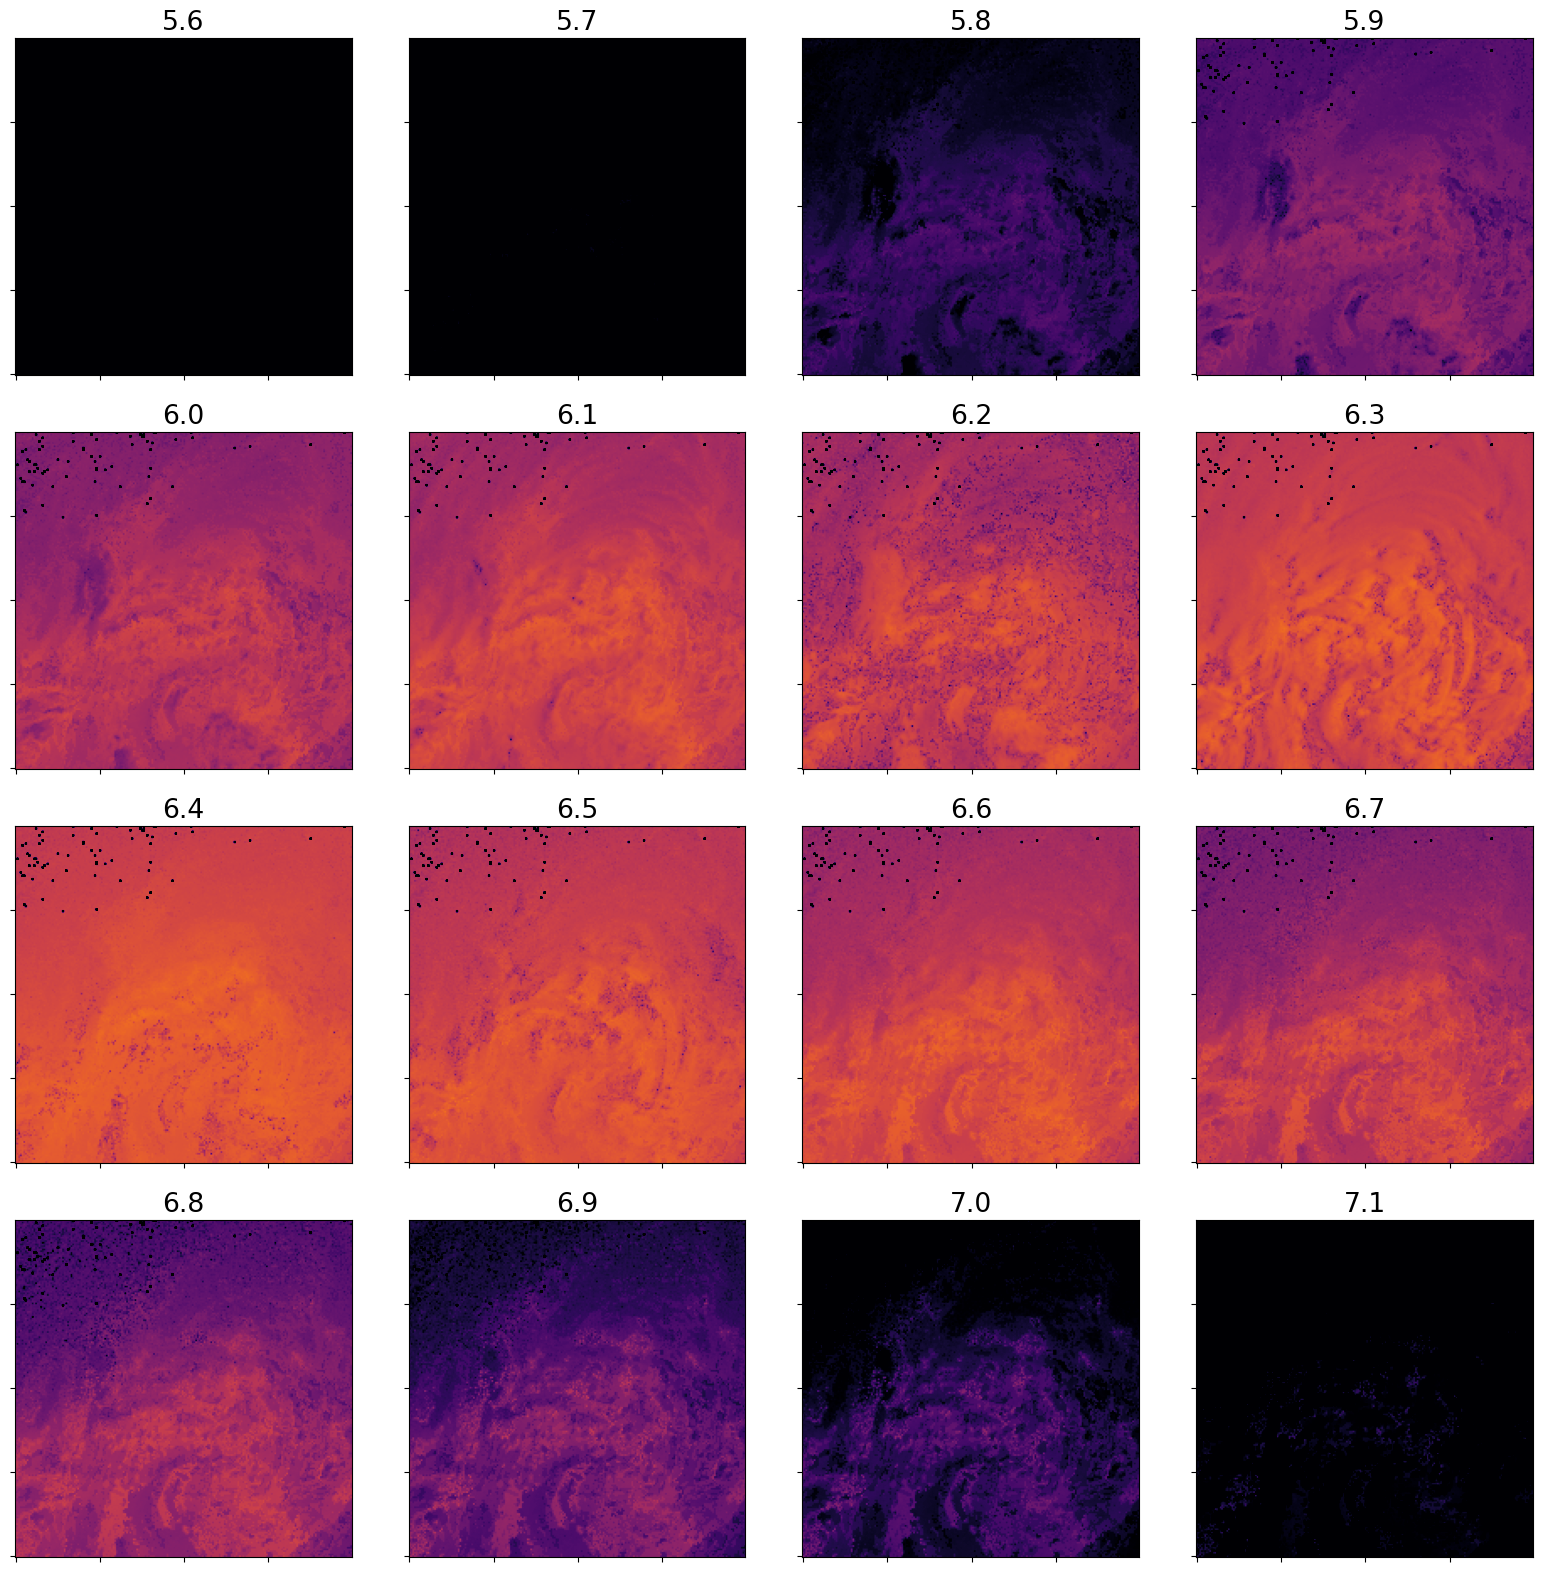

In [109]:
fig=plt.figure(figsize=(16, 16))
for j in range(16):
    fig=plt.subplot(4,4,j+1)
    plt.imshow(np.log10(dem[:,:,j]+1e-20),'inferno',vmin=17,vmax=25,origin='lower')
    ax=plt.gca()
    ax.set_title('%.1f'%(5.6+j*0.1))
    ax.set_yticklabels([])
    ax.set_xticklabels([])

plt.tight_layout()

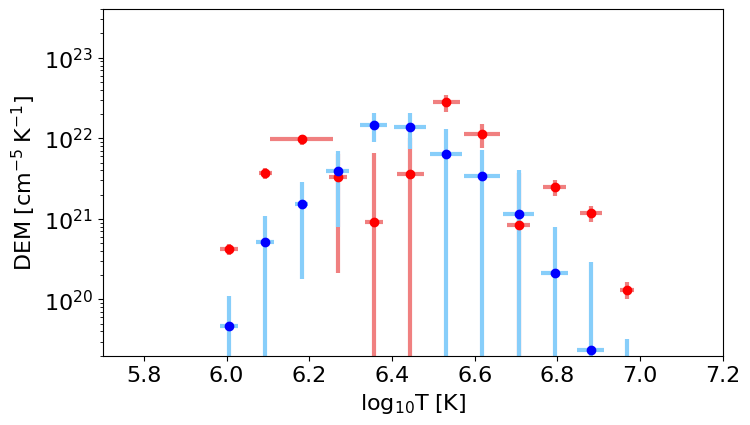

In [110]:
yr=[2e19,4e23]
xr=[5.7,7.2]
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem[94,106,:],xerr=elogt[94,106,:],yerr=edem[94,106,:],fmt='or',\
             ecolor='lightcoral', elinewidth=3, capsize=0)
plt.errorbar(mlogt,dem[100,100,:],xerr=elogt[100,100,:],yerr=edem[94,106,:],fmt='ob',\
             ecolor='lightskyblue', elinewidth=3, capsize=0)
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim(yr)
plt.xlim(xr)
plt.rcParams.update({'font.size': 16})
plt.yscale('log')

plt.show()

In [88]:
(int(np.floor(np.argmax(dem[:,:,14])/200)),
np.mod(np.argmax(dem[:,:,14]),200))

(94, 106)

[<Quantity 94. Angstrom>,
 <Quantity 131. Angstrom>,
 <Quantity 171. Angstrom>,
 <Quantity 193. Angstrom>,
 <Quantity 211. Angstrom>,
 <Quantity 335. Angstrom>]

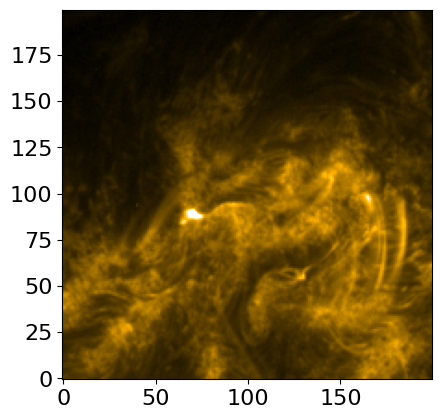

In [25]:
plt.imshow(np.sqrt(maps[2].data[x1:x2,y1:y2]),vmax=np.sqrt(4000), cmap=maps[2].cmap, origin='lower')
channels

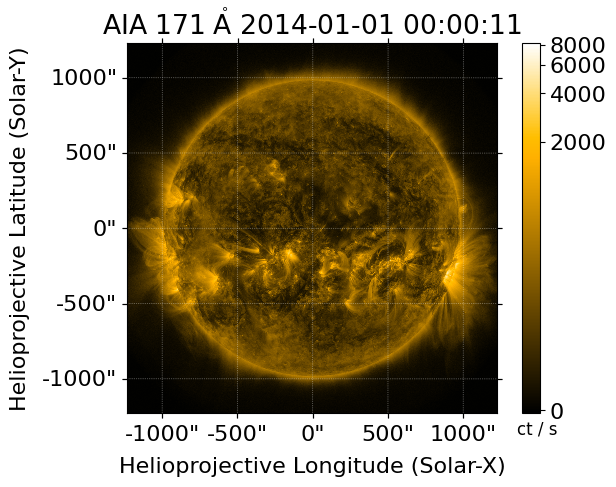

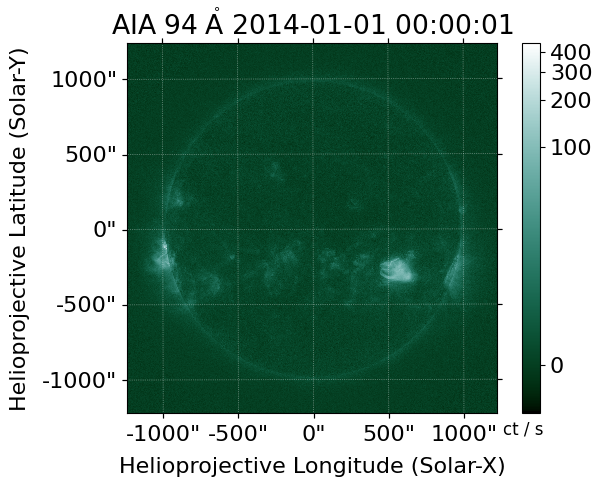

12

In [47]:
maps[2].peek()
maps[0].peek()
nt